In [1]:
## Get data

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from trajectory import rat_trajectory
from scipy.interpolate import interp1d

#Perameters
shape = 'Sqr'

# cell_name = f' C{cell_num:03}'
spk_filename = f'data/B6_8_1_{shape}_Spike.csv'
trc_filename = f'data/B6_8_1_{shape}_Trace.csv'

# Read the CSV file
df = pd.read_csv(trc_filename, header=None)

# Get cell numbers
cell_numbers = df.iloc[0].dropna().tolist()[1:]
trace_per_cell = {cell: [] for cell in cell_numbers}

# Get time data
time_data = [float(i) for i in df.iloc[2:, 0].tolist()]
start_time = time_data[0]
time_data = [time_data[i] - start_time for i in range(len(time_data))]

traj_time, x_pos, y_pos, head_dir, velocity = rat_trajectory(shape)


# get trace data from each cell + interpolate
for i in range(np.shape(df.iloc[2:])[1] - 1):
    cell_name = np.asarray(cell_numbers)[i]
    trace_data = [float(i) for i in df.iloc[2:, i+1].tolist()]
    time_interp = interp1d(time_data, trace_data)

    trace_data = time_interp(traj_time)
    trace_data = (trace_data - np.mean(trace_data)) / np.std(trace_data)
    trace_per_cell[cell_name] = trace_data.tolist()

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
## NaN interpolation ##
# For x_pos
invalid_x_pos = np.isnan(x_pos)
x_pos_interp = x_pos.copy()
x_valid = np.where(~invalid_x_pos)[0]
x_pos_interp[invalid_x_pos] = np.interp(np.where(invalid_x_pos)[0], x_valid, x_pos[x_valid])

# For y_pos
invalid_y_pos = np.isnan(y_pos)
y_pos_interp = y_pos.copy()
y_valid = np.where(~invalid_y_pos)[0]
y_pos_interp[invalid_y_pos] = np.interp(np.where(invalid_y_pos)[0], y_valid, y_pos[y_valid])

# For HD
invalid_hd = np.isnan(head_dir)
hd_interp = head_dir.copy()
hd_valid = np.where(~invalid_hd)[0]
hd_interp[invalid_hd] = np.interp(np.where(invalid_hd)[0], hd_valid, head_dir[hd_valid])

# For vel
invalide_vel = np.isnan(velocity)
vel_interp = velocity.copy()
vel_valid = np.where(~invalide_vel)[0]
vel_interp[invalide_vel] = np.interp(np.where(invalide_vel)[0], vel_valid, velocity[vel_valid])

# Update the original arrays
x_pos = x_pos_interp
y_pos = y_pos_interp
head_dir = hd_interp
velocity = vel_interp

# discard index where velocity < threshold
threshold = 2
moving_idx = [i for i, x in enumerate(velocity) if x > threshold]


In [3]:
def find_nearest_time_index(spike_time, traj_time):
    return np.argmin(np.abs(np.array(traj_time) - spike_time))

total_trace = np.zeros((len(traj_time), len(cell_numbers)))

# Iterate through cells and their spike times
for i, cell in enumerate(cell_numbers):
    total_trace[:, i] = np.asarray(trace_per_cell[cell])

print(np.shape(total_trace))

(26989, 77)


In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.collections import LineCollection

import cebra.datasets
import cebra
from cebra import CEBRA

In [5]:
max_iterations = 1000 #default is 5000.

In [6]:
index = [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67, 9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]
boundary = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

neural = total_trace[:, index] #index at 2

In [7]:
if shape == 'Hex':
    # normalize
    x_pos = x_pos / 10
    y_pos = y_pos / 10

    # to radial coordinates
    x_pos_ori, y_pos_ori = x_pos, y_pos
    theta = np.arctan(x_pos / y_pos)
    rad = np.sqrt(x_pos ** 2 + y_pos ** 2)
    continuous_index = np.column_stack((rad, theta, head_dir/180))

elif shape == 'Tri':
    d_left = np.abs(1.586 * x_pos - y_pos + 25.241) / 1.876
    d_right = np.abs(-1.846 * x_pos - y_pos + 24.462) / 2.103
    d_bottom = np.abs(-0.036 * x_pos - y_pos - 16.836) / 1.001

    #normalize
    d_left, d_right, d_bottom = d_left/10, d_right/10, d_bottom/10
    continuous_index = np.column_stack((d_left, d_right, d_bottom))

elif shape == 'Sqr':
    # normalize
    x_pos = x_pos / 10
    y_pos = y_pos / 10

    min_x = np.min(x_pos)
    max_x = np.max(x_pos)
    min_y = np.min(y_pos)
    max_y = np.max(y_pos)

    continuous_index = np.column_stack((x_pos-min_x, max_x-x_pos, y_pos-min_y, max_y-y_pos))

print(continuous_index)

[[0.26139  4.38898  1.207223 3.544587]
 [0.25805  4.39232  1.263649 3.488161]
 [0.29353  4.35684  1.397354 3.354456]
 ...
 [4.07865  0.57172  3.78696  0.96485 ]
 [4.07928  0.57109  3.79265  0.95916 ]
 [4.08455  0.56582  3.80796  0.94385 ]]


In [22]:
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=1,
    n_components=8,  # or whatever dimensionality you want
    metric='cosine',
    random_state=42
)

neural = total_trace[:, index]
embeddings = umap_model.fit_transform(np.hstack([neural, continuous_index]))

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_53191/3172824426.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2],


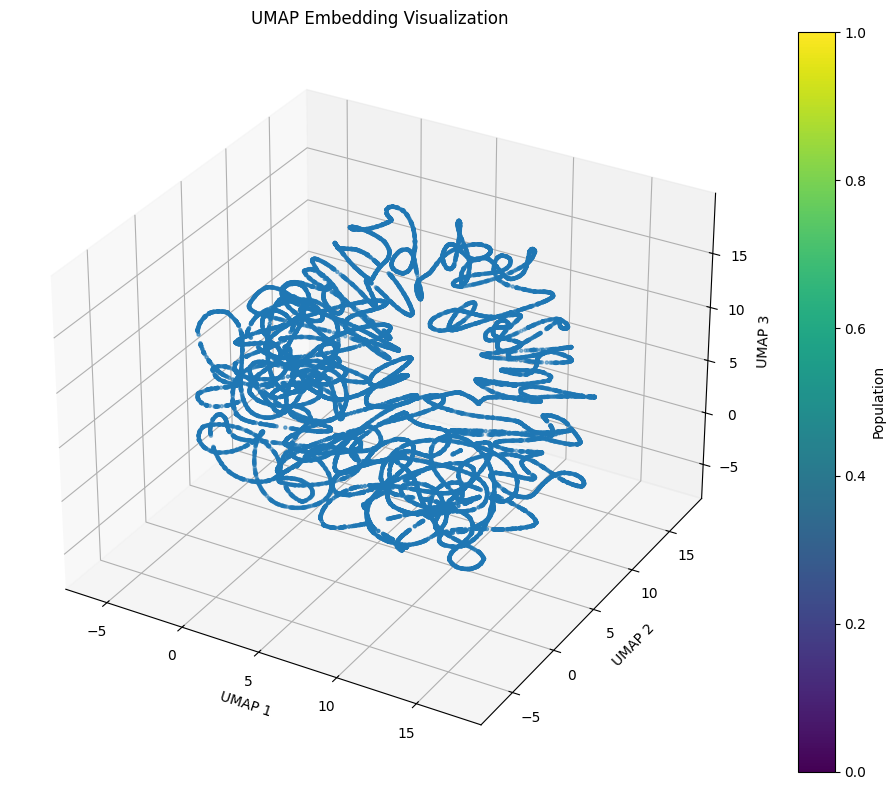

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'embeddings' contains your UMAP output
# and 'population_labels' contains your 0/1 labels

# Create a new figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], 
                    cmap='coolwarm', s=5)

# Add a color bar
plt.colorbar(scatter, label='Population')

# Set labels
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')

plt.title('UMAP Embedding Visualization')
plt.tight_layout()

# Save the figure
plt.savefig('umap_visualization.png', dpi=300)

# Show the plot (optional)
plt.show()

In [42]:
print(cmap(1))

(0.063536, 0.028426, 0.533124, 1.0)


In [43]:
def write_ply(filename, points, colors):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for i in range(len(points)):
            f.write(f"{points[i, 0]} {points[i, 1]} {points[i, 2]} {colors[i, 0]} {colors[i, 1]} {colors[i, 2]}\n")


dist_from_center = np.sqrt(((max_x + min_x)/2 - x_pos)**2 + ((max_y + min_y)/2 - y_pos)**2)
norm = plt.Normalize(dist_from_center.min(), dist_from_center.max())
normalized_index = norm(dist_from_center)

# Choose colormap ('cool' or 'viridis')
cmap = plt.get_cmap('plasma')  # or 'viridis'

# Get RGB values (0-1 range)
colors_float = cmap((continuous_index[:, 0] < 0.7)*255)[:, :3]

# Convert to 0-255 range for PLY file
colors = (colors_float * 255).astype(int)

# Write the PLY file
write_ply("embeddings_visualization.ply", embeddings, colors)

In [19]:
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=1,
    n_components=8,  # or whatever dimensionality you want
    metric='euclidean',
    random_state=42
)

index_1 = [4, 7, 18, 25, 29, 30, 31, 33, 37, 43, 51, 53, 54, 55, 60, 65, 66, 67]
neural = total_trace[:, index_1]
embeddings1 = umap_model.fit_transform(np.hstack([neural, continuous_index]))

dist_from_center = np.sqrt(((max_x + min_x)/2 - x_pos)**2 + ((max_y + min_y)/2 - y_pos)**2)
norm = plt.Normalize(dist_from_center.min(), dist_from_center.max())
normalized_index = norm(dist_from_center)

cmap = plt.get_cmap('plasma')
colors_float = cmap(normalized_index)[:, :3]
colors = (colors_float * 255).astype(int)

# Write the PLY file
write_ply("embeddings1_visualization.ply", embeddings1, colors)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=1,
    n_components=8,  # or whatever dimensionality you want
    metric='euclidean',
    random_state=42
)

index_2 = [9, 10, 13, 15, 21, 22, 23, 36, 38, 41, 42, 47, 52, 59, 61, 73]
neural = total_trace[:, index_2]
embeddings2 = umap_model.fit_transform(np.hstack([neural, continuous_index]))

dist_from_center = np.sqrt(((max_x + min_x)/2 - x_pos)**2 + ((max_y + min_y)/2 - y_pos)**2)
norm = plt.Normalize(dist_from_center.min(), dist_from_center.max())
normalized_index = norm(dist_from_center)

cmap = plt.get_cmap('plasma')
colors_float = cmap(normalized_index)[:, :3]
colors = (colors_float * 255).astype(int)

# Write the PLY file
write_ply("embeddings2_visualization.ply", embeddings2, colors)

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [48]:

blue = np.array([0, 0, 1])  # RGB for blue
orange = np.array([1, 0.5, 0])  # RGB for orange

# Create color array
colors = np.zeros((len(embeddings1) + len(embeddings2), 3))
colors[:len(embeddings1)] = blue
colors[len(embeddings1):] = orange

# If you need the colors as uint8 (0-255 range) for some visualizations:
colors_uint8 = (colors * 255).astype(np.uint8)

write_ply("embeddings12.ply", np.concatenate([embeddings1, embeddings2]), colors_uint8)